# Get a LSST Simulated Cadence for Arbitrary Sky Position
___


___

In [1]:
"""

"""
%matplotlib inline

from __future__ import print_function

try:
    from importlib import reload
except:
    pass


from matplotlib import pyplot as plt
import matplotlib.colors as mpl_colors 

import os
import sys
import warnings

import numpy as np
import pandas as pd
import astropy as ap
import sfdmap

import sqlite3
from sqlalchemy import create_engine

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table

import lsst_tools.utils as utils 
import lsst_tools.utils.colours as colours 

import pyCoCo as pccsims
import pycoco as pcc

Connect to .db file that contains the opsim output, read into a dataframe, `opsimdf`

In [4]:
# %%timeit ## 1 loop, best of 3: 1min 31s per loop 
opsimdbpath = os.environ.get('OPSIMDBPATH')
# print(opsimdbpath)
# opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/astro_lsst_01_1068_sqlite.db"
opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/minion_1016_sqlite.db"

conn = create_engine('sqlite:///'+opsimdbpath, echo = False)
opsimdf = pd.read_sql_table('Summary', con=conn)

Check that the db looks as we expect

In [8]:
opsimdf.head()

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,moonBright,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec
0,1,1016,54,316,1.676483,-1.082473,y,2922,59580.033829,0,...,0.0,105.610378,0.920473,0.0,0.0,1.620307,0.000000,21.021236,1.643930,-1.108924
1,2,1016,54,372,1.694120,-1.033972,y,2961,59580.034275,0,...,0.0,105.167017,0.920473,0.0,0.0,0.049266,4.574944,21.026646,1.664257,-1.060423
2,3,1016,54,441,1.708513,-0.985271,y,2999,59580.034722,0,...,0.0,104.849578,0.920473,0.0,0.0,0.049298,4.595615,21.030520,1.680878,-1.011722
3,4,1016,54,505,1.720374,-0.936476,y,3038,59580.035169,0,...,0.0,104.669398,0.920473,0.0,0.0,0.049266,4.605366,21.032718,1.694604,-0.962927
4,5,1016,54,587,1.730248,-0.887672,y,3077,59580.035616,0,...,0.0,104.627207,0.920473,0.0,0.0,0.049177,4.604023,21.033233,1.706054,-0.914123


Connecting to `.db` takes ages (~1min), and is a pain if you mess up, so create a 'working' instance to fiddle with

In [12]:
working_df = opsimdf

In [9]:
#%%timeit ## The slowest run took 39.04 times longer than the fastest. This could mean that an intermediate result is being cached.
#         ## 1000 loops, best of 3: 246 µs per loop
n = 1
pos_df = utils.generate_coordinates(n)
# pos_df["phi"] = -0.122
# pos_df["theta"] = 0.0

Add extinction to the dataframe

In [10]:
#%%timeit ## 1 loop, best of 3: 88.6 ms per loop
df = utils.find_MW_extinction(pos_df) 

Check the positions are sensible

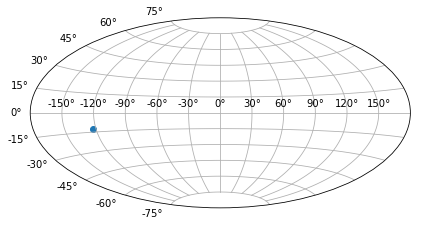

In [11]:
#%%timeit ## 1 loop, best of 3: 235 ms per loop
utils.plot_position_points(df)

## Identifying Fields
___
We want to find out which field(s) the position is in. Create table that tells us the field centres, and find the edges.

In [ ]:
# working_df = utils.get_field_corners(working_df.drop_duplicates("fieldID"))[['fieldRA', 'fieldDec']]
allfields_df = utils.get_field_corners(pd.DataFrame(working_df.drop_duplicates("fieldID"))[['fieldID', 'fieldRA', 'fieldDec']])

In [ ]:
fields_df.head()

,fieldID,fieldRA,fieldDec,RA_upper,RA_lower,Dec_upper,Dec_lower
0,505,1.720374,-0.936476,1.750917,1.689831,-0.967019,-0.905933
1,567,1.648235,-0.903353,1.678778,1.617692,-0.933896,-0.872810
2,561,1.563788,-0.915583,1.594331,1.533245,-0.946126,-0.885040
3,539,1.477422,-0.924531,1.507965,1.446879,-0.955074,-0.893988
4,531,1.389669,-0.930365,1.420212,1.359126,-0.960908,-0.899822
5,517,1.301075,-0.933239,1.331618,1.270532,-0.963782,-0.902696
6,519,1.212198,-0.933238,1.242741,1.181655,-0.963781,-0.902695
7,523,1.123604,-0.930366,1.154147,1.093061,-0.960909,-0.899823
8,541,1.035849,-0.924530,1.066392,1.005306,-0.955073,-0.893987
9,698,0.988892,-0.827713,1.019435,0.958349,-0.858256,-0.797170


In [ ]:
field_df = fields_df[(fields_df["RA_upper"] >= df["theta"][0] + np.pi) &
                (fields_df["RA_lower"] <= df["theta"][0] + np.pi) &
                (fields_df["Dec_lower"] >= df["phi"][0])  &
                (fields_df["Dec_upper"] <= df["phi"][0])]

In [ ]:
field_df

In [ ]:
opsimdf = utils.find_MW_extinction(opsimdf)

## Deep Drilling Fields:
___

* minion2016: 1427,744,2412,290,2786
* astro_lsst_01_1068: 1427,744,2412,290,2786
* Fake_Rolling: 290,2786


In [ ]:
opsimdf.loc[opsimdf["fieldID"] == 505].head() ## WFD

In [ ]:
opsimdf.loc[opsimdf["fieldID"] == 1427].head() ## DDF

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec,EBV_MW
228,229,1068,248,1427,0.925184,-0.4789,r,12021,59580.139144,0,...,84.581506,0.866285,0.0,0.0,0.665408,140.0,24.020509,0.907976,-0.505351,0.007715
229,230,1068,248,1427,0.925184,-0.4789,r,12057,59580.139560,0,...,84.902366,0.791241,0.0,0.0,0.000000,2.0,24.093428,0.907976,-0.505351,0.007715
230,231,1068,248,1427,0.925184,-0.4789,r,12093,59580.139977,0,...,84.970046,0.791241,0.0,0.0,0.000000,2.0,24.092267,0.907976,-0.505351,0.007715
231,232,1068,248,1427,0.925184,-0.4789,r,12129,59580.140394,0,...,85.038172,0.791241,0.0,0.0,0.000000,2.0,24.091099,0.907976,-0.505351,0.007715
232,233,1068,248,1427,0.925184,-0.4789,r,12165,59580.140810,0,...,85.106747,0.859965,0.0,0.0,0.000000,2.0,24.017937,0.907976,-0.505351,0.007715
233,234,1068,248,1427,0.925184,-0.4789,r,12201,59580.141227,0,...,85.175771,0.859965,0.0,0.0,0.000000,2.0,24.016755,0.907976,-0.505351,0.007715
234,235,1068,248,1427,0.925184,-0.4789,r,12237,59580.141644,0,...,85.245246,0.859965,0.0,0.0,0.000000,2.0,24.015564,0.907976,-0.505351,0.007715
235,236,1068,248,1427,0.925184,-0.4789,r,12273,59580.142060,0,...,85.315173,0.859965,0.0,0.0,0.000000,2.0,24.014368,0.907976,-0.505351,0.007715
236,237,1068,248,1427,0.925184,-0.4789,r,12309,59580.142477,0,...,85.385554,0.859965,0.0,0.0,0.000000,2.0,24.013163,0.907976,-0.505351,0.007715
237,238,1068,248,1427,0.925184,-0.4789,r,12345,59580.142894,0,...,85.456390,0.859965,0.0,0.0,0.000000,2.0,24.011952,0.907976,-0.505351,0.007715


In [ ]:
# mjdmax = np.random.choice(mjd_to_sim)
# mjdmax = np.random.choice(mjd_to_sim)
# 
# chosenfield = 550 ## WFD
chosenfield = 2297
# chosenfield = 2786 ## DDF

mjd_to_sim = opsimdf.loc[opsimdf["fieldID"] == chosenfield,["expMJD"]].values.T[0]
filters_to_sim = opsimdf.loc[opsimdf["fieldID"] == chosenfield,["filter"]].values.T[0]
limiting_mags = opsimdf.loc[opsimdf["fieldID"] == chosenfield,["fiveSigmaDepth"]].values.T[0] 

filters_to_sim = np.array([b('LSST_'+x) for x in filters_to_sim])

In [58]:
mjd_to_sim = working_df["expMJD"][working_df["fieldID"].isin(working_df["fieldID"].values)].values
filters_to_sim = working_df["filter"][working_df["fieldID"].isin(working_df["fieldID"].values)].values
limiting_mags = working_df["fiveSigmaDepth"][working_df["fieldID"].isin(working_df["fieldID"].values)].values

## Extinction

Get the Milky Way extinction along the line of site towards the SNe

In [64]:
extinction = opsimdf.loc[opsimdf["fieldID"] == chosenfield,["EBV_MW"]].head(1).values[0][0]
print(extinction)

0.122651721609


In [ ]:
print(opsimdf.loc[opsimdf["fieldID"] == chosenfield,["fieldRA"]].head(1).values[0][0])
print(opsimdf.loc[opsimdf["fieldID"] == chosenfield,["fieldDec"]].head(1).values[0][0])


In [ ]:
# filter_path = "/Users/berto/Code/CoCo/data/filters"
filter_path = pcc._default_filter_dir_path
# coco_root_path = "/Users/berto/Code/CoCo"
coco_root_path = pcc._default_coco_dir_path 

coco = pccsims.pyCoCo(b(filter_path), b(coco_root_path))

In [ ]:
# mjd_to_sim = np.array([90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 105.0, 110.0, 115.0, 120.0])
# filters_to_sim = np.array([b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r'])
# mjd_to_sim = 
# filters_to_sim = 

inputs:

* **`snname`**
* **`redshift`**
* **`absmag offset`**
* **`EBV MW`**
* **`EBV Host`**
* **`Rv`**
* **`MJD at Peak`**

* **`MJD to simulate`**
* **`filters to simulate`**

In [ ]:
# z_obs = 0.007
# z_obs = 0.1
z_obs = 0.2
host_EBV = 0.2
MW_EBV = extinction
# mjdmax = 60307.314753999999
# mjdmax = 59580 + 1.* 365. ## DDF 2786
# mjdmax = 59580 + 1.5* 365. ## WFD 550
mjdmax = 59580 + 1.3* 365. ## WFD 2297

In [ ]:
plt.scatter(mjd_to_sim, np.ones(len(mjd_to_sim)))
plt.scatter([mjdmax], [1])

In [ ]:
# flux, flux_err = coco.simulate(b"SN2007uy", 
#                     z_obs, 0.0, MW_EBV, host_EBV, 3.1, 
#                     mjdmax, mjd_to_sim, 
#                     filters_to_sim)
snname = b"SN2007uy"
# snname = b"SN2009jf"
flux, flux_err = coco.simulate(snname, 
                    z_obs, 0.0, MW_EBV, host_EBV, 3.1, 
                    mjdmax, mjd_to_sim, 
                    filters_to_sim)
# flux, flux_err = coco.simulate(b"SN2009jf", 
#                     z_obs, 0.0, 0.1, 0.1, 3.1, 
#                     mjdmax, mjd_to_sim, 
#                     filters_to_sim)

In [ ]:
flux, flux_err

In [ ]:
mjdmax 

In [ ]:
p = pcc.PhotometryClass()
pt = simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim)
pt_lim_m = pt
pt_lim_m["fivesigmadepth"] = limiting_mags

In [ ]:
pt = pt_lim_m[np.where(pt_lim_m["flux"] > 1e-22)]

In [ ]:
pt

In [ ]:
days_before = 40
days_after = 100
print(mjdmax)
w = np.where(np.logical_and(pt["MJD"] > mjdmax - days_before, pt["MJD"] < mjdmax + days_after))
print(w)
pt[w]

In [ ]:
print(snname)
print(chosenfield)
print(z_obs)
print(extinction)
print(opsimdbpath)
print(mjdmax)

In [ ]:
reload(pcc)
reload(pcc.classes)
# reload(pcc.utils)

In [ ]:
p.load_table(pt[w], verbose= True)


p.plot()

In [ ]:
p.unpack(verbose = True)

In [ ]:
phot_table = p.phot.loc["filter", "LSST_u"]

In [ ]:
phot_table

In [ ]:
phot_table.meta["filter_filename"] = "foo"

In [ ]:
pt[w]

In [ ]:
# filter_file_type = '.dat'
# filter_names = np.unique(pt[w]["filter"])
# print(filter_names)
# pt.add_index('filter', unique = True)
# for filter_name in filter_names:
# #     phot_table = self.phot.loc["filter", filter_name]
#     filter_filename = filter_name + filter_file_type
#     print(filter_filename)

In [ ]:
# reload(pcc)
# phot = pcc.PhotometryClass()
# infile = "/Users/berto/projects/LSST/cadence/lightcurves/SNSim_0002_minion_1016_SN2007uy_z=02_EBVMW=0029_EBVHOST=01_fieldID=2297WFD.dat"
# phot.load(path = infile, names = ("MJD", "flux", "flux_err", "filter", "fivesigmadepth"), verbose = True)
# # phot.load_phot_from_file(path = infile, format = "ascii.commented_header")

# phot.unpack(verbose = True)

In [ ]:
# phot.data

In [ ]:
# phot_table = Table.read(infile, names = ("MJD", "flux", "flux_err", "filter", "fivesigmadepth"), format = "ascii")

In [ ]:
# phot_table.meta["filename"] = infile

# phot_table["MJD"].unit = u.day
# phot_table["flux"].unit = u.cgs.erg / u.si.angstrom / u.si.cm ** 2 / u.si.s
# phot_table["flux_err"].unit =  phot_table["flux"].unit

In [ ]:
# reload(pcc)
# p = pcc.PhotometryClass()
# p.load_table(phot_table, verbose = True)